In [1]:
#import libraries
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
from math import sqrt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib import colors
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os

#set plot size for all plots
plt.rcParams["figure.figsize"] = (10,6)

In [2]:
#loading data and adding column names
col_names = ["date", "value"]
df=pd.read_csv('Electric_Production.csv',names = col_names, header = 0, parse_dates = [0])
df = df.set_index(['date'])
df.head()

,value
date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


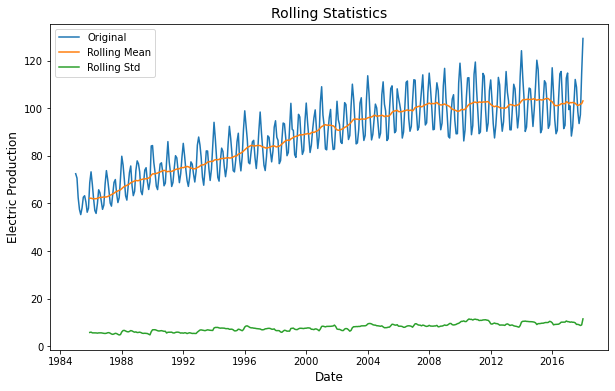

In [3]:
#Rolling statistics
rolling_mean = df.rolling(window=12).mean()
rolling_std = df.rolling(window=12).std()

plt.plot(df, label='Original')
plt.plot(rolling_mean,label='Rolling Mean')
plt.plot(rolling_std,label='Rolling Std')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size  = 12)
plt.legend(loc = 'upper left')
plt.title('Rolling Statistics', size = 14)
plt.show()

ADF Statistic: -2.257
p-value: 0.186
##################################
Critical Values:
1%: -3.448
5%: -2.869
10%: -2.571
##################################
ADF > Critical Values
Failed to reject null hypothesis, time series is non-stationary.


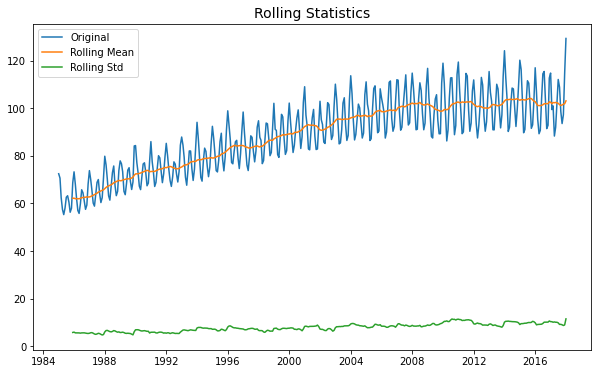

In [4]:
#function to check whether data is stationary or not
#Augmented Dickey-Fuller Test

def adfuller_test(ts, window = 12):
    
    movingAverage = ts.rolling(window).mean()
    movingSTD = ts.rolling(window).std()
    
    plt.plot(ts,label='Original')
    plt.plot(movingAverage,label='Rolling Mean')
    plt.plot(movingSTD,label='Rolling Std')
    plt.legend(loc = 'upper left')
    plt.title('Rolling Statistics', size = 14)
    
    adf = adfuller(ts, autolag='AIC')
    
    print('ADF Statistic: {}'.format(round(adf[0],3)))
    print('p-value: {}'.format(round(adf[1],3)))
    print("##################################")  
    print('Critical Values:')
    
    for key, ts in adf[4].items():
         print('{}: {}'.format(key, round(ts,3)))
    print("##################################")
    
    if adf[0] > adf[4]["5%"]:
        print("ADF > Critical Values")
        print ("Failed to reject null hypothesis, time series is non-stationary.")
    else:
        print("ADF < Critical Values")
        print ("Reject null hypothesis, time series is stationary.")
        
adfuller_test(df, window = 12)

ADF Statistic: -3.145
p-value: 0.023
##################################
Critical Values:
1%: -3.448
5%: -2.869
10%: -2.571
##################################
ADF < Critical Values
Reject null hypothesis, time series is stationary.


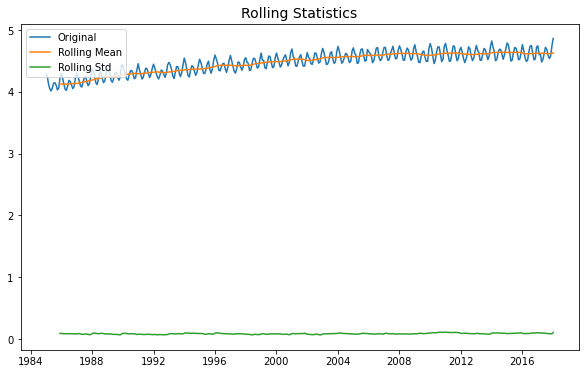

In [5]:
df_log = np.log(df) #logarithmic transformation
adfuller_test(df_log, window = 12)

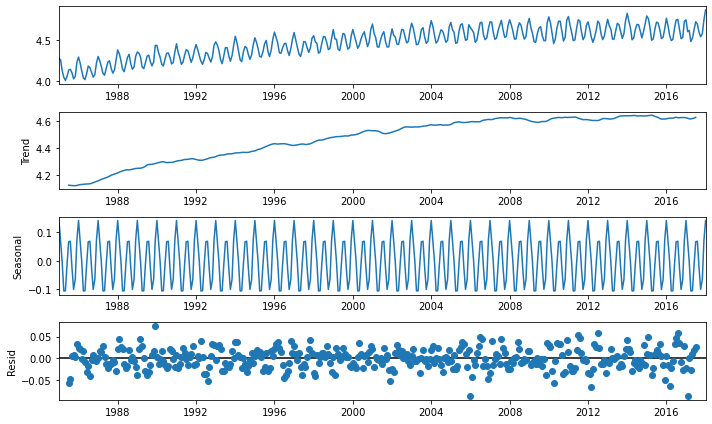

In [6]:
df_seasonal_decompose = seasonal_decompose(df_log,model='duplicative')
df_seasonal_decompose.plot()
plt.show()

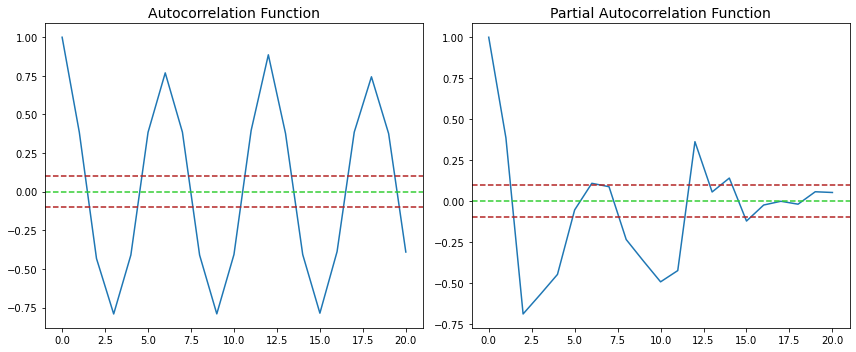

In [12]:
df_acf = acf(df_log_shift, nlags=20) #auto correlation
df_pacf = pacf(df_log_shift, nlags=20, method='ols') #partial auto correlation

fig, axs = plt.subplots(1, 2, figsize =(12,5))

plt.subplot(121)
plt.plot(df_acf)
plt.axhline(y=0, linestyle='--', color='limegreen')
plt.axhline(y=-1.96/np.sqrt(len(df_log)),linestyle='--', color='firebrick')
plt.axhline(y=1.96/np.sqrt(len(df_log)),linestyle='--', color='firebrick')
plt.title('Autocorrelation Function', size = 14)            

plt.subplot(122)
plt.plot(df_pacf)
plt.axhline(y=0, linestyle='--', color='limegreen')
plt.axhline(y=-1.96/np.sqrt(len(df_log)),linestyle='--', color='firebrick')
plt.axhline(y=1.96/np.sqrt(len(df_log)),linestyle='--', color='firebrick')
plt.title('Partial Autocorrelation Function', size = 14)
            
plt.tight_layout() 

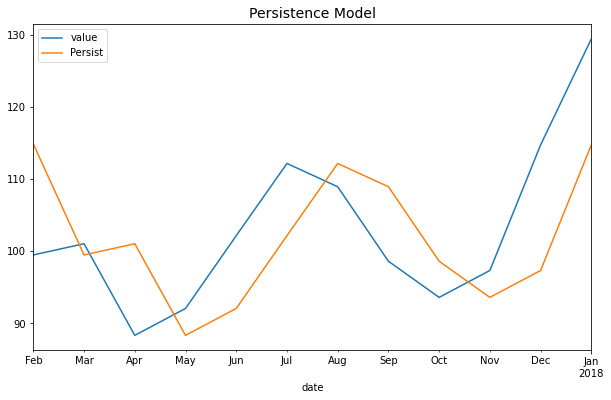

In [9]:
#Persistence Model
values = pd.DataFrame(df_log.values)
per_df = pd.concat([values.shift(1), values], axis=1)
per_df.columns = ['t-1', 't+1']
per_value = per_df.values

train = per_value[1:len(per_value)-12] 
test = per_value[len(per_value)-12:]

X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]

def persistence(x):
    return x

predictions = []
for i in X_test:
    y_pred = persistence(i)
    predictions.append(y_pred)

test_data=df[-len(test):]
test_data['Persist']=np.exp(predictions)
#test_data

test_data['value'].plot( legend=True)
test_data['Persist'].plot(legend = True)
plt.title("Persistence Model", size = 14)
plt.show()

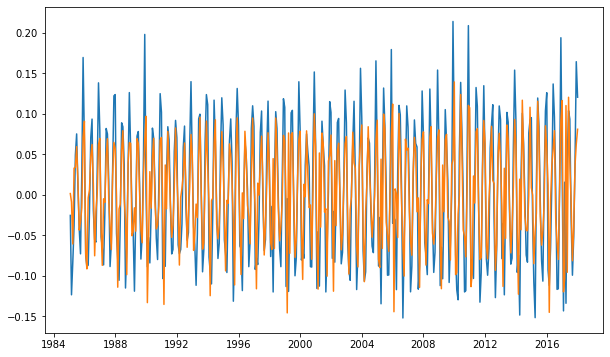

In [11]:
#AR model
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
AR_model = ARIMA(df_log, order=(2,1,0)) #gives AR model q=0
AR_results = AR_model.fit()
plt.plot(df_log_shift)
plt.plot(AR_results.fittedvalues)

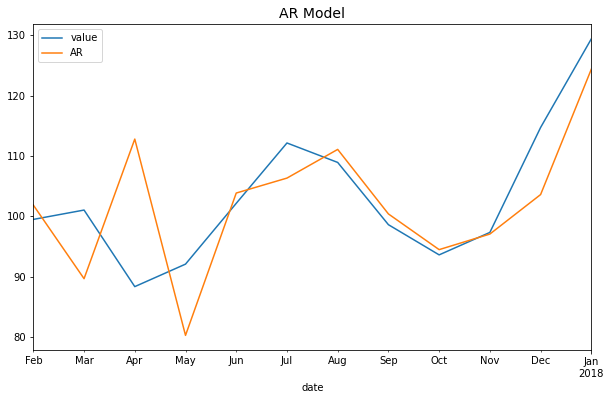

In [13]:
ar_pred=AR_results.predict(len(train),len(train)+len(test),typ='levels',dynamic=False) # predicting values
ar_pred1=np.exp(ar_pred)  #inverse of transformation taken
test_data['AR']=ar_pred1
test_data['value'].plot( legend=True)
test_data['AR'].plot(legend = True)
plt.title("AR Model", size = 14)
plt.show()

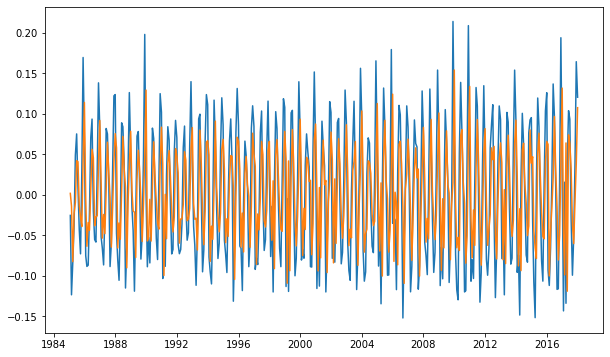

In [14]:
#MA model
MA_model = ARIMA(df_log, order=(0,1,2))  #gives MA model p=0
MA_results = MA_model.fit()
plt.plot(df_log_shift)
plt.plot(MA_results.fittedvalues)

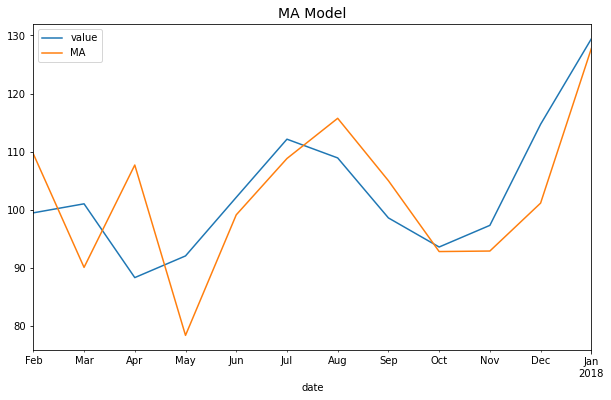

In [15]:
ma_pred=MA_results.predict(len(train),len(train)+len(test),typ='levels',dynamic=False) # predicting values 
ma_pred1=np.exp(ma_pred)  # inverse transformation
test_data['MA']=ma_pred1
test_data['value'].plot( legend=True)
test_data['MA'].plot(legend = True)
plt.title("MA Model", size = 14)
plt.show()

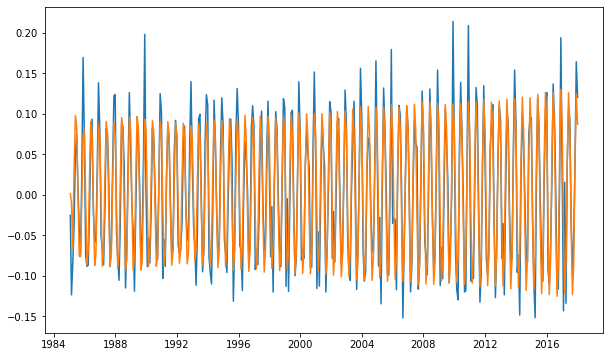

In [16]:
#ARIMA model
ARIMA_model = ARIMA(df_log, order=(2,1,2))
ARIMA_results = ARIMA_model.fit()
plt.plot(df_log_shift)
plt.plot(ARIMA_results.fittedvalues)

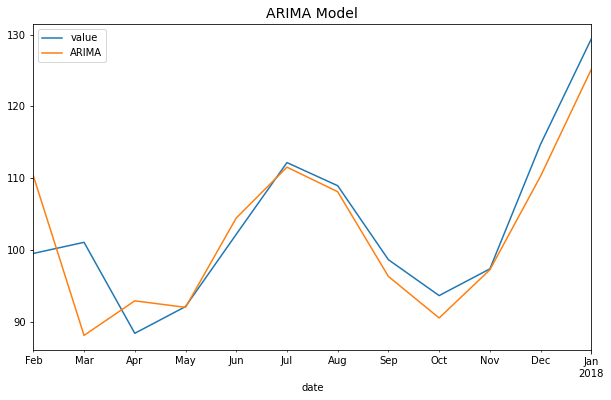

In [17]:
arima_pred=ARIMA_results.predict(len(train),len(train)+len(test),typ='levels',dynamic=False) #predicting values
arima_pred1=np.exp(arima_pred) #inverse transformation
test_data['ARIMA']=arima_pred1
test_data['value'].plot(legend=True)
test_data['ARIMA'].plot(legend = True)
plt.title("ARIMA Model", size = 14)
plt.show()

In [25]:
#LSTM model
#splitting data into train and test 
train_data = df[:len(df)-12]
test_data1 = df[len(df)-12:]

#preprocessing- transformation of data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data1)

from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 200)               161600    
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [32]:
lstm_model.fit_generator(generator,epochs=30)

Epoch 1/30
373/373 [==============================] - 2s 6ms/step - loss: 0.0022
Epoch 2/30
373/373 [==============================] - 3s 7ms/step - loss: 0.0020
Epoch 3/30
373/373 [==============================] - 2s 6ms/step - loss: 0.0020
Epoch 4/30
373/373 [==============================] - 3s 8ms/step - loss: 0.0020
Epoch 5/30
373/373 [==============================] - 3s 7ms/step - loss: 0.0021
Epoch 6/30
373/373 [==============================] - 3s 7ms/step - loss: 0.0021
Epoch 7/30
373/373 [==============================] - 2s 5ms/step - loss: 0.0021
Epoch 8/30
373/373 [==============================] - 2s 7ms/step - loss: 0.0020
Epoch 9/30
373/373 [==============================] - 3s 8ms/step - loss: 0.0018
Epoch 10/30
373/373 [==============================] - 2s 6ms/step - loss: 0.0019
Epoch 11/30
373/373 [==============================] - 2s 5ms/step - loss: 0.0019
Epoch 12/30
373/373 [==============================] - 2s 6ms/step - loss: 0.0020
Epoch 13/30
373/373 [====

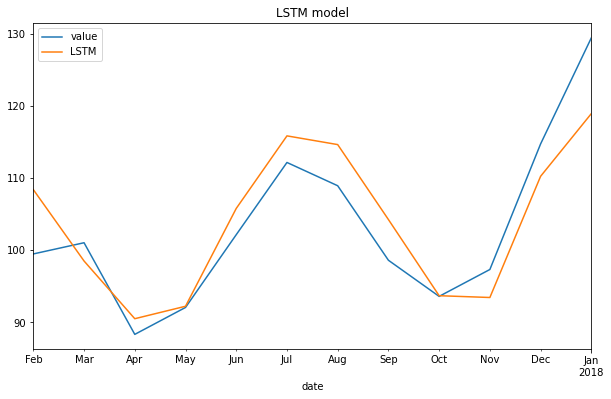

In [34]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data1)):   
    lstm_pred = lstm_model.predict(current_batch)[0] #predicting values 
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled) # inverse transformation
test_data['LSTM'] = lstm_predictions
test_data['value'].plot(legend=True)
test_data['LSTM'].plot(legend = True)
plt.title('LSTM model')

plt.show()

In [35]:
test_data  # contains all predicted values from different methods and original values

,value,Persist,AR,MA,ARIMA,LSTM
date,,,,,,
2017-02-01,99.4901,114.8505,101.861505,109.631207,110.312426,108.394167
2017-03-01,101.0396,99.4901,89.672015,90.110597,88.065765,98.510726
2017-04-01,88.3530,101.0396,112.800482,107.711305,92.882264,90.522581
2017-05-01,92.0805,88.3530,80.275298,78.418837,91.971657,92.244685
2017-06-01,102.1532,92.0805,103.858270,99.144456,104.429893,105.788164
2017-07-01,112.1538,102.1532,106.336145,108.832309,111.517617,115.836134
2017-08-01,108.9312,112.1538,111.088587,115.746060,108.091181,114.628411
2017-09-01,98.6154,108.9312,100.397221,105.013935,96.277596,104.252236
2017-10-01,93.6137,98.6154,94.483069,92.832136,90.492360,93.707039


In [36]:
#calculating mean squared error for the methods used
persistence_score=mean_squared_error(test_data['value'], test_data['Persist'])
print('Persistence MSE: {}'.format(round(persistence_score,4)))

ar_score=mean_squared_error(test_data['value'], test_data['AR'])
print('AR MSE: {}'.format(round(ar_score,4)))

ma_score=mean_squared_error(test_data['value'], test_data['MA'])
print('MA MSE: {}'.format(round(ma_score,4)))

arima_score=mean_squared_error(test_data['value'], test_data['ARIMA'])
print('ARIMA MSE: {}'.format(round(arima_score,4)))

lstm_score=mean_squared_error(test_data['value'], test_data['LSTM'])
print('LSTM MSE: {}'.format(round(lstm_score,4)))

Persistence MSE: 107.349
AR MSE: 88.8421
MA MSE: 91.4873
ARIMA MSE: 30.4447
LSTM MSE: 27.2127


In [37]:
#displaying errors in order 
errors = pd.DataFrame()
errors["Model"] = ["Persistence", "Autoregression", "Moving Average", "ARIMA",'LSTM']
errors["MSE"] = [persistence_score, ar_score, ma_score, arima_score,lstm_score]
errors = errors.sort_values("MSE", ascending = True, ignore_index = True)
errors.index = errors.Model
del errors["Model"]

def coloring_bg(s, min_, max_, cmap='Reds', low=0, high=0):
    color_range = max_ - min_
    norm = colors.Normalize(min_ - (color_range * low), max_ + (color_range * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

errors.style.apply(coloring_bg,min_ =errors.min().min(),
               max_ = errors.max().max(), low = 0.1, high = 0.85)

,MSE
Model,
LSTM,27.212700
ARIMA,30.444707
Autoregression,88.842098
Moving Average,91.487276
Persistence,107.348968
